<a href="https://colab.research.google.com/github/zeinabmohamed/MedicalChatbot/blob/main/medical_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## imports

In [1]:
# stopwords
!pip install --user -U nltk
import nltk
from nltk.corpus import stopwords
# keras
from keras import backend as K
from keras.layers import Layer
from keras.preprocessing.sequence import pad_sequences
# numpy
import numpy as np
import itertools
# Basic package
from time import time
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from gensim.models import KeyedVectors
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Flatten, Activation, RepeatVector, Permute, Lambda, \
    Bidirectional, TimeDistributed, Dropout, Conv1D, GlobalMaxPool1D
from keras.layers.merge import multiply, concatenate
import keras.backend as K
from tensorflow.keras.optimizers import Adam
## donwnload binary files
!pip install wget
import wget
## Google news embedding model

     |████████████████████████████████| 1.5 MB 5.1 MB/s 
     |████████████████████████████████| 748 kB 46.7 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=5772fac1abdedb55734f40d32da82c1c149a6e9c4c2e2a2e393fbdf716f6d150
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


## Load stopwords

In [2]:
nltk.download('stopwords')
stops_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Downlaod GoogleNews-vectors-negative300

In [3]:
url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
filename = wget.download(url)

## Helper Funcations

#### Data preprocessing

###### Text to list

In [4]:
def text_to_word_list(text):  # Text segmentation
    text = str(text)
    text = text.lower()
    # Text cleaning rules for English text
    import re
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

###### Words embedding

In [12]:
def make_w2v_embeddings(flag,word2vec, df, embedding_dim):  # Convert words to word vectors
    vocabs = {}  # word number
    vocabs_count = 0  # word count counter

    vocabs_not_w2v = {}  # words that cannot be represented by word vectors
    vocabs_not_w2v_count = 0  # Word count that cannot be represented by word vectors

    for index, row in df.iterrows():
        # print processing progress
        if index != 0 and index % 1000 == 0:
            print(str(index) + " sentences embedded.")

        for question in ['question1', 'question2']:
            q2n = []  # q2n -> question to numbers representation
            words = text_to_word_list(row[question])

            for word in words:
                if word in stops_words:  # remove stop words
                  continue
                # The word of OOV is put into a dictionary that cannot be represented by a word vector, and the value is 1
                if word not in word2vec and word not in vocabs_not_w2v:  
                    vocabs_not_w2v_count += 1
                    vocabs_not_w2v[word] = 1   
                if word not in vocabs:  # Non-OOV words, extract the corresponding id
                    vocabs_count += 1
                    vocabs[word] = vocabs_count
                    q2n.append(vocabs_count)
                else:
                    q2n.append(vocabs[word])
            df.at[index, question + '_n'] = q2n

    embeddings = 1 * np.random.randn(len(vocabs) + 1, embedding_dim)  # Randomly initialize a matrix of shape [number of all words, word vector dimension]
  
    embeddings[0] = 0  #The first row is filled with 0, because there is no word with index 0

    for index in vocabs:
        vocab_word = vocabs[index]
        if vocab_word in word2vec:
            embeddings[index] = word2vec[vocab_word]
    del word2vec

    return df, embeddings

###### Add Zero padding

In [6]:
def split_and_zero_padding(df, max_seq_length):  # Adjust the length of tokens

    # Convert training set matrix to dictionary
    X = {'left': df['question1_n'], 'right': df['question2_n']}

    # Adjust to the specified length
    for dataset, side in itertools.product([X], ['left', 'right']):
        dataset[side] = pad_sequences(dataset[side], padding='pre', truncating='post', maxlen=max_seq_length)

    return dataset

###### Setup Similarity funaction : ManDist

In [7]:
class ManDist(Layer):  # Manhattan distance calculation encapsulated into keras layer

    # Initialize the ManDist layer, no parameter input is required at this time
    def __init__(self, **kwargs):
        self.result = None
        super(ManDist, self).__init__(**kwargs)

    # Automatically build ManDist layer
    def build(self, input_shape):
        super(ManDist, self).build(input_shape)

    # Calculate Manhattan distance
    def call(self, x, **kwargs):
        self.result = K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
        return self.result

    # return result
    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)

## Model Hyperparameter

In [8]:
# ------------------Preloading------------------ #
# English training options, English training set is used by default

TRAIN_CSV = './train.csv'
embedding_path = 'GoogleNews-vectors-negative300.bin.gz'
flag = 'en'
embedding_dim = 300
max_seq_length = 32
batch_size = 64
n_epoch = 6
n_hidden = 100

savepath = './en_BILSTM_Attnetion_Model.h5'

## Load word2vec

In [9]:
# Whether to enable pre-trained word vectors, use randomly initialized word vectors by default
# Load word vectors
print("Loading word2vec model(it may takes 2-3 mins) ...")
embedding_dict = KeyedVectors.load_word2vec_format(embedding_path, binary=True)
print("Loading word2vec model Done 🎉")

Loading word2vec model(it may takes 2-3 mins) ...
Loading word2vec model Done 🎉


##Read and load the training set

In [10]:
train_df = pd.read_csv(TRAIN_CSV)
for q in ['question1', 'question2']:
    train_df[q + '_n'] = train_df[q]

##Vectorize the training set words

In [13]:
train_df, embeddings = make_w2v_embeddings(flag, embedding_dict, train_df, embedding_dim=embedding_dim)

1000 sentences embedded.
2000 sentences embedded.
3000 sentences embedded.
4000 sentences embedded.
5000 sentences embedded.
6000 sentences embedded.
7000 sentences embedded.
8000 sentences embedded.
9000 sentences embedded.


In [14]:
train_df['lenq1'] = train_df['question1'].astype(str).str.len()
train_df['lenq2'] = train_df['question2'].astype(str).str.len()
train_df['lenq1_n'] = len(train_df['question1_n'])
train_df['lenq2_n'] = len(train_df['question2_n'])

train_df

,id,qid1,qid2,question1,question2,is_duplicate,question1_n,question2_n,lenq1,lenq2,lenq1_n,lenq2_n
0,31,63,64,What are some special cares for someone with a...,How can I keep my nose from getting stuffy at ...,1,"[1, 2, 3, 4, 5, 6, 7]","[8, 4, 9, 6, 7]",86,52,9998,9998
1,50,101,102,Is Career Launcher good for RBI Grade B prepar...,How is career launcher online program for RBI ...,1,"[10, 11, 12, 13, 14, 15, 16]","[10, 11, 17, 18, 13, 14, 15]",52,54,9998,9998
2,50,101,102,Is Career Launcher good for RBI Grade B prepar...,How is career launcher online program for RBI ...,1,"[10, 11, 12, 13, 14, 15, 16]","[10, 11, 17, 18, 13, 14, 15]",52,54,9998,9998
3,58,117,118,I was suddenly logged off Gmail. I can't remem...,I can't remember my Gmail password or my recov...,1,"[19, 20, 21, 22, 23, 21, 24, 25, 26, 27, 28, 29]","[22, 23, 21, 24, 26, 27, 30, 27]",139,85,9998,9998
4,61,123,124,Is it normal to have a dark ring around the ir...,What causes a dark ring around the iris? How s...,0,"[31, 32, 33, 34, 35, 36]","[37, 32, 33, 34, 35, 38]",59,66,9998,9998
...,...,...,...,...,...,...,...,...,...,...,...,...
9993,403892,537514,201639,Why am I so scared all the time?,Why am I so scared?,1,"[246, 758]",[246],32,19,9998,9998
9994,403892,537514,201639,Why am I so scared all the time?,Why am I so scared?,1,"[246, 758]",[246],32,19,9998,9998
9995,404050,316912,537677,Why are panic attacks treated at the emergency...,"Which was bigger, Alderaan or the Death Star?",0,"[6358, 6359, 38, 7941, 1001]","[306, 11584, 2478, 286]",52,45,9998,9998
9996,404162,396010,29003,What are the options for a chemical engineer a...,What are the career opportunities after finish...,1,"[410, 1489, 296, 15, 842]","[10, 1117, 1490, 1489, 329]",58,71,9998,9998


##max_seq_length_in_dataset

In [15]:
max_seq_length_in_dataset = max(train_df.question1_n.map(lambda x: len(x)).max(),
                     train_df.question2_n.map(lambda x: len(x)).max())
print("max_seq_length_in_dataset : ",max_seq_length_in_dataset)


max_seq_length_in_dataset :  51


In [16]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_n,question2_n,lenq1,lenq2,lenq1_n,lenq2_n
0,31,63,64,What are some special cares for someone with a...,How can I keep my nose from getting stuffy at ...,1,"[1, 2, 3, 4, 5, 6, 7]","[8, 4, 9, 6, 7]",86,52,9998,9998
1,50,101,102,Is Career Launcher good for RBI Grade B prepar...,How is career launcher online program for RBI ...,1,"[10, 11, 12, 13, 14, 15, 16]","[10, 11, 17, 18, 13, 14, 15]",52,54,9998,9998
2,50,101,102,Is Career Launcher good for RBI Grade B prepar...,How is career launcher online program for RBI ...,1,"[10, 11, 12, 13, 14, 15, 16]","[10, 11, 17, 18, 13, 14, 15]",52,54,9998,9998
3,58,117,118,I was suddenly logged off Gmail. I can't remem...,I can't remember my Gmail password or my recov...,1,"[19, 20, 21, 22, 23, 21, 24, 25, 26, 27, 28, 29]","[22, 23, 21, 24, 26, 27, 30, 27]",139,85,9998,9998
4,61,123,124,Is it normal to have a dark ring around the ir...,What causes a dark ring around the iris? How s...,0,"[31, 32, 33, 34, 35, 36]","[37, 32, 33, 34, 35, 38]",59,66,9998,9998


# Base Model function
Take the training data from: 
question1   question2   is_duplicate
borrow Repayment Information Borrow Repayment Date 0
become:

question1 question2 is_duplicate question1_n question2_n
Borrow repayment information Borrow repayment date 0 Borrow repayment information Borrow repayment date

After becoming id:
question1 question2 is_duplicate question1_n question2_n
Borrow repayment information Borrow repayment date 0 [31, 639] [31, 255]

## Split training set 80:20

In [17]:
X = train_df[['question1_n', 'question2_n']]
Y = train_df['is_duplicate']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

X_train = split_and_zero_padding(X_train, max_seq_length)
X_validation = split_and_zero_padding(X_validation, max_seq_length)

## Convert labels to numbers

In [18]:
Y_train = Y_train.values
Y_validation = Y_validation.values

## Confirm that the data is prepared and correct

In [19]:
print("X_train['left'].shape" , X_train['left'].shape)
print("X_train['right'].shape" , X_train['left'].shape)
print("len(X_train['left'])" , len(X_train['left']))
print("len(Y_train)" , len(Y_train))

assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

X_train['left'].shape (7998, 32)
X_train['right'].shape (7998, 32)
len(X_train['left']) 7998
len(Y_train) 7998


In [20]:
print(Y_validation)

[1 1 1 ... 1 1 1]


## Hierarchical BiLSTM attention model Funaction  [**HBAM**]

---



In [21]:
def hbam_model(_input):
    # word vectorization
    embedded = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_shape=(max_seq_length,),
                         trainable=False)(_input)

    # multilayerBi-LSTM
    activations = Bidirectional(LSTM(n_hidden, return_sequences=True), merge_mode='concat')(embedded)
    activations = Bidirectional(LSTM(n_hidden, return_sequences=True), merge_mode='concat')(activations)

    # dropout
    activations = Dropout(0.5)(activations)

    # Attention
    attention = TimeDistributed(Dense(1, activation='tanh'))(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(n_hidden * 2)(attention)
    attention = Permute([2, 1])(attention)
    sent_representation = multiply([activations, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)

    # dropout
    sent_representation = Dropout(0.2)(sent_representation)

    return sent_representation

## Train Function

In [22]:
if __name__ == '__main__':

    left_input = Input(shape=(max_seq_length,), dtype='float32')
    right_input = Input(shape=(max_seq_length,), dtype='float32')

    left_sen_representation = hbam_model(left_input)
    right_sen_representation = hbam_model(right_input)

    # The Manhattan distance is introduced, and the original 
    #vector on the obtained transformation concat is 
    #then subjected to a non-linear transformation 
    #through a multi-layer DNN, and the sigmoid obtains the similarity
    
    # I did not use the Mahalanobis distance mentioned 
    #in https://zhuanlan.zhihu.com/p/31638132. 
    #I tried Manhattan distance, point product and cos, 
    #and Manhattan is the best.
    
    man_distance = ManDist()([left_sen_representation, right_sen_representation])
    sen_representation = concatenate([left_sen_representation, right_sen_representation, man_distance])
    similarity = Dense(1, activation='sigmoid')(Dense(2)(Dense(4)(Dense(16)(sen_representation))))
    model = Model(inputs=[left_input, right_input], outputs=[similarity])

    model.compile(loss='mean_squared_error', optimizer= Adam(), metrics=['accuracy'])
    model.summary()

    training_start_time = time()
    malstm_trained = model.fit([X_train['left'], X_train['right']], Y_train,
                               batch_size=batch_size, epochs=n_epoch,
                               validation_data=([X_validation['left'], X_validation['right']], Y_validation))
    training_end_time = time()
    print("Training time finished.\n%d epochs in %12.2f" % (n_epoch, training_end_time - training_start_time))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 300)      3475800     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 32, 300)      3475800     ['input_2[0][0]']                
                                                                                              

## Plot Accuracy & Loss 

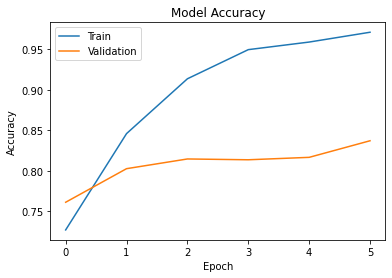

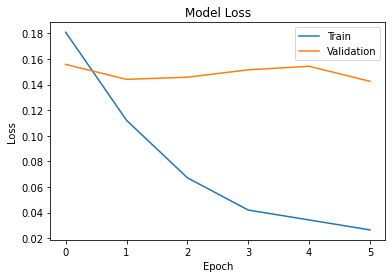

0.8370(max: 0.8370)
Done.


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [23]:

import matplotlib.pyplot as plt
#plt.subplot(211)
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
#plt.subplot(212)
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

model.save(savepath)
print(str(malstm_trained.history['val_accuracy'][-1])[:6] +"(max: " + str(max(malstm_trained.history['val_accuracy']))[:6] + ")")
print("Done.")
